In [1]:
import glob
import re
import json 
import itertools
import functools
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from scipy import stats

mpl.rc('font', family='Arial', size=12)

In [2]:
mats = glob.glob('../../genome_correlations/tss_unexpr/*.temp')

In [3]:
sample_extractor = re.compile('/([^/]+)\.([mp]).temp')

In [4]:
filename_correspondence = {f: sample_extractor.findall(f)[0] 
                           for f in mats 
                           if any(i in f for i in ('dmso', 'drb', 'gl3')) and '_1' not in f}

In [5]:
filename_correspondence

{'../../genome_correlations/tss_unexpr/dmso_2.m.temp': ('dmso_2', 'm'),
 '../../genome_correlations/tss_unexpr/dmso_2.p.temp': ('dmso_2', 'p'),
 '../../genome_correlations/tss_unexpr/dmso_3.m.temp': ('dmso_3', 'm'),
 '../../genome_correlations/tss_unexpr/dmso_3.p.temp': ('dmso_3', 'p'),
 '../../genome_correlations/tss_unexpr/dmso_in.m.temp': ('dmso_in', 'm'),
 '../../genome_correlations/tss_unexpr/dmso_in.p.temp': ('dmso_in', 'p'),
 '../../genome_correlations/tss_unexpr/drb_2.m.temp': ('drb_2', 'm'),
 '../../genome_correlations/tss_unexpr/drb_2.p.temp': ('drb_2', 'p'),
 '../../genome_correlations/tss_unexpr/drb_3.m.temp': ('drb_3', 'm'),
 '../../genome_correlations/tss_unexpr/drb_3.p.temp': ('drb_3', 'p'),
 '../../genome_correlations/tss_unexpr/drb_in.m.temp': ('drb_in', 'm'),
 '../../genome_correlations/tss_unexpr/drb_in.p.temp': ('drb_in', 'p'),
 '../../genome_correlations/tss_unexpr/drb_rh.m.temp': ('drb_rh', 'm'),
 '../../genome_correlations/tss_unexpr/drb_rh.p.temp': ('drb_rh', 'p

In [6]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

In [7]:
tss_data = {}
for filename, samplename in filename_correspondence.items():
    print(samplename)
    tss_data[samplename] = read_matrix_file(filename)

('dmso_2', 'm')
('dmso_2', 'p')
('dmso_3', 'm')
('dmso_3', 'p')
('dmso_in', 'm')
('dmso_in', 'p')
('drb_2', 'm')
('drb_2', 'p')
('drb_3', 'm')
('drb_3', 'p')
('drb_in', 'm')
('drb_in', 'p')
('drb_rh', 'm')
('drb_rh', 'p')
('gl3_2', 'm')
('gl3_2', 'p')
('gl3_3', 'm')
('gl3_3', 'p')
('gl3_in', 'm')
('gl3_in', 'p')
('gl3_rh', 'm')
('gl3_rh', 'p')


In [8]:
with open('../../pair_counts.json') as f:
    read_pairs = json.load(f)
million_mapped = {k: v/2e6 for k, v in read_pairs.items()}

In [9]:
spike_counts = pd.read_csv('../../spike_in_counts_bwa_minus_strand.tsv', sep = '\t', 
                           names = ('template', 'read_count', 'sample_name'))

In [10]:
spikein_matrix = (spike_counts.groupby(['sample_name', 'template']).read_count.mean().unstack().fillna(0) //2)

In [11]:
mean_spike_counts = (spikein_matrix.iloc[:, [1,4]].mean(axis=1) /100).to_dict()

In [12]:
gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_GENCODE_v29_symbols.tsv', sep='\t',
                        names = ('gencode', 'symbol', 'gencode_2', 'chr', 'strand', 'start', 'end', 
                                 'cd_start', 'cd_end', 'exon_count', 'exon_starts', 'exon_ends', 'prot_id', 'align_id'),
                        usecols = ('chr', 'start', 'end', 'strand', 'symbol', 'align_id', 'gencode'), header = 0
                       )

In [13]:
used_genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/HeLa_expression/Hela_non_expressed_full_genes.bed',
                         sep ='\t', names = ('chr', 'start', 'end', 'gencode', 'expr', 'strand'))

In [14]:
used_genes = used_genes.merge(gene_data[['strand', 'gencode', 'symbol']], how='left')

In [15]:
used_genes['ucsc_name'] = ucsc_index(used_genes)

In [16]:
used_genes.head()

,chr,start,end,gencode,expr,strand,symbol,ucsc_name
0,chr1,52472,53312,ENST00000606857.1,0,+,OR4G4P,chr1:52472-53312
1,chr1,57597,64116,ENST00000642116.1,0,+,OR4G11P,chr1:57597-64116
2,chr1,69054,70108,ENST00000335137.4,0,+,OR4F5,chr1:69054-70108
3,chr1,131024,134836,ENST00000442987.3,0,+,CICP27,chr1:131024-134836
4,chr1,135140,135895,ENST00000494149.2,0,-,AL627309.6,chr1:135140-135895


In [17]:
used_genes = used_genes.set_index('ucsc_name')

In [18]:
sense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'm'}
for sample, matrix in sense_data.items():
    if '_1' not in sample:
        matrix.loc[used_genes.strand == '-', :] = tss_data[(sample, 'p')].loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()
antisense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'p'}
for sample, matrix in antisense_data.items():
    if '_1' not in sample:
        matrix.loc[used_genes.strand == '-', :] = tss_data[(sample, 'm')].loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()

In [19]:
len(gc_skew)

NameError: name 'gc_skew' is not defined

In [ ]:
gc_skew.loc[used_genes.strand == '-', :] = -gc_skew.loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()

In [ ]:
sense_data.keys()

In [ ]:
fig, ax = plt.subplots()

for sample, matrix in sense_data.items():
    if ('in' not in sample)  and 'rh' not in sample:
        ax.plot(matrix.loc[(matrix.mean(axis=1) > 0.01) & 
                           (matrix.mean(axis=1) < 10), :].mean(axis=0),
                label = sample)

# Chymograph plot with Groseq expression

In [25]:
groseq_rpkm = pd.read_hdf('/Volumes/Pegasus/shared_files/bed_files/hg38/HeLa_expression/rpkm_values_groseq.hdf')

In [26]:
groseq_rpkm.head()

,chr,start,end,transcript,rep1_p,rep2_p,rep1_m,rep2_m,strand,mean_sense_reads
0,chr1,11868,14409,ENST00000456328.2,0.187619,0.082893,4.065069,1.707606,+,0.135256
1,chr1,14403,29570,ENST00000488147.1,0.628653,0.024998,1.823093,1.780383,-,1.801738
2,chr1,17368,17436,ENST00000619216.1,0.000000,0.000000,7.010865,12.390139,-,9.700502
3,chr1,29553,31097,ENST00000473358.1,3.293532,0.109136,0.205846,0.109136,+,1.701334
4,chr1,30365,30503,ENST00000607096.1,0.000000,0.000000,0.000000,0.000000,+,0.000000


In [27]:
used_genes = used_genes.merge(groseq_rpkm[['transcript', 'mean_sense_reads']], left_on='gencode', right_on='transcript', how='left')

In [30]:
mean_ip_data = (sense_data['gl3_2']/million_mapped['gl3_2'] + 
                sense_data['gl3_3']/million_mapped['gl3_3'])/2

(0, 0.4)

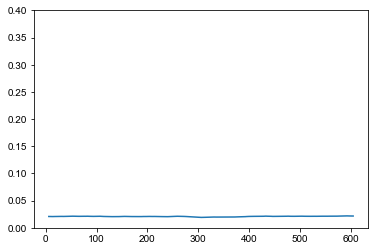

In [31]:
fig, ax = plt.subplots()
plt.plot(mean_ip_data.mean(axis=0))
ax.set_ylim(0, 0.4)

In [32]:
def order_by_matrix(out_mat, order_mat = None, agg_func = functools.partial(np.mean, axis=1), top_n = None):
    if top_n is None:
        top_n = len(out_mat)
    if type(out_mat) == pd.DataFrame:
        out_mat = out_mat.as_matrix()
    if order_mat is None:
        order_mat = out_mat
    return out_mat[np.argsort(agg_func(order_mat))[::-1][0:top_n], :]

def nice_matplot(mat, ax, **matshow_kwargs):
    if 'vmin' not in matshow_kwargs:
        matshow_kwargs['vmin'] = 0
    if 'vmax' not in matshow_kwargs:
        matshow_kwargs['vmax'] = 2
    if 'extent' not in matshow_kwargs:
        matshow_kwargs['extent'] = [-3,3,0,15]
    if 'cmap' not in matshow_kwargs:
        matshow_kwargs['cmap'] = 'Greys' 
    ax.matshow(mat, **matshow_kwargs)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)

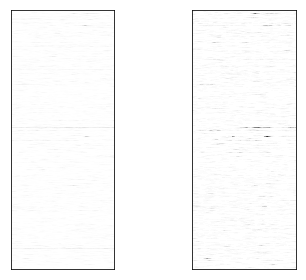

In [33]:
fig, ax = plt.subplots(ncols = 2)

def no_op(x):
    return x

order_matrix = used_genes.mean_sense_reads

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n=5000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix,agg_func=no_op, top_n=5000), ax=ax[1], vmax=2)
fig.tight_layout()

In [43]:
expr_genes = mean_ip_data
expr_rh = sense_data['gl3_rh'] / million_mapped['gl3_rh']
expr_in = sense_data['gl3_in']/ million_mapped['gl3_in']

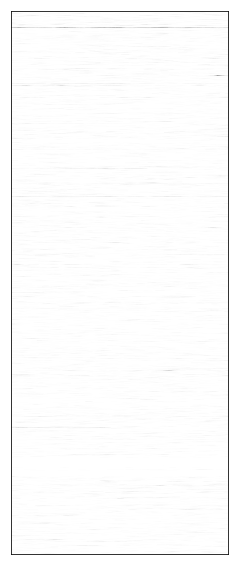

In [35]:
fig, ax = plt.subplots(figsize=(4,10))
expr_genes = order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n = 10335)[335:, :]
expr_rh = order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix , agg_func=no_op, top_n = 10355)[335:, :]
expr_in = order_by_matrix(sense_data['gl3_in']/ million_mapped['gl3_in'], order_matrix , agg_func=no_op, top_n = 10355)[335:, :]
nice_matplot(expr_genes, ax=ax, vmax=2)

In [36]:
len(mean_ip_data), len(order_matrix)

(12227, 12227)

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


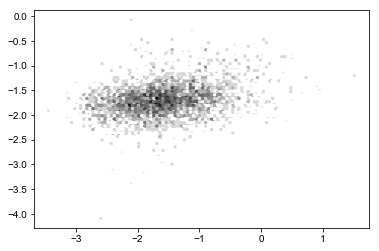

In [37]:
fig, ax = plt.subplots()
x,y = np.log10(used_genes.mean_sense_reads), np.log10(mean_ip_data.mean(axis=1))
mask = np.isfinite(x.as_matrix()) & np.isfinite(y.as_matrix())
ax.hexbin(x[mask], y[mask], bins='log', cmap='Greys')

In [81]:
np.corrcoef(x[mask], y[mask])

array([[1.       , 0.6375937],
       [0.6375937, 1.       ]])

In [84]:
stats.pearsonr(x[mask], y[mask])

(0.6375936970143559, 0.0)

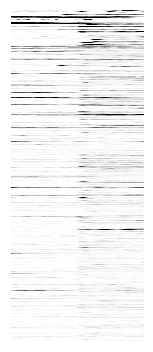

In [45]:
fig, ax = plt.subplots(figsize=(3.5,5))
nice_matplot(order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n = 10000), ax=ax, vmax=2)
fig.tight_layout()
ax.axis('off') # Remove frame around plot
fig.savefig('top_10000_R-loops_gene_expression.png', dpi=300)
fig.savefig('top_10000_R-loops_gene_expression.pdf')

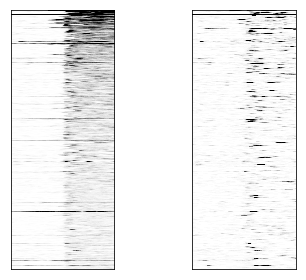

In [46]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = mean_ip_data.iloc[:, 300:].as_matrix() - mean_ip_data.iloc[:, :300].as_matrix()

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

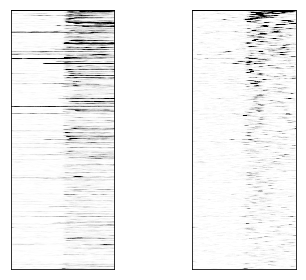

In [47]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = sense_data['gl3_rh'].iloc[:, 300:].as_matrix() - sense_data['gl3_rh'].iloc[:, :300].as_matrix()

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

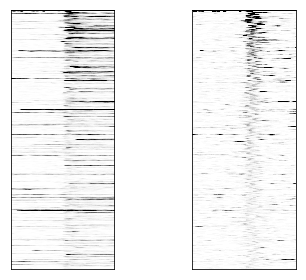

In [38]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = sense_data['gl3_rh'].iloc[:, 300:400]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

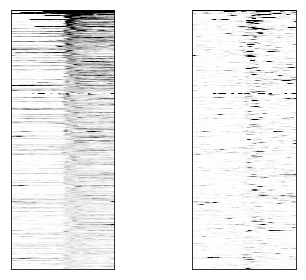

In [39]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = mean_ip_data.iloc[:, 300:400]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

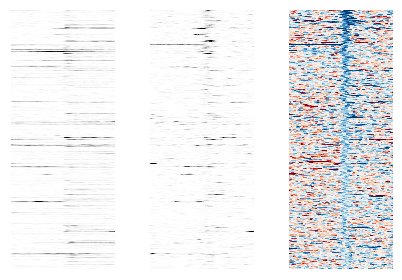

In [43]:
fig, ax = plt.subplots(ncols = 3)

order_matrix = gc_skew.iloc[:, 300:350]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=10000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=10000), ax=ax[1], vmax=2)
nice_matplot(order_by_matrix(gc_skew, order_matrix, top_n=10000), ax=ax[2], vmax=0.5, vmin=-0.5, cmap='RdBu')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.tight_layout()
fig.savefig('ip_and_rh_and_skew.png', dpi=400)

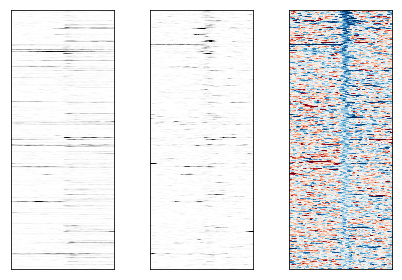

In [48]:
fig, ax = plt.subplots(ncols = 3)

order_matrix = gc_skew.iloc[:, 300:350]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=10000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=10000), ax=ax[1], vmax=2)
nice_matplot(order_by_matrix(gc_skew, order_matrix, top_n=10000), ax=ax[2], vmax=0.5, vmin=-0.5, cmap='RdBu')
fig.tight_layout()
fig.savefig('ip_and_rh_and_skew.png', dpi=400)

In [43]:
?mpl.cm.ScalarMappable

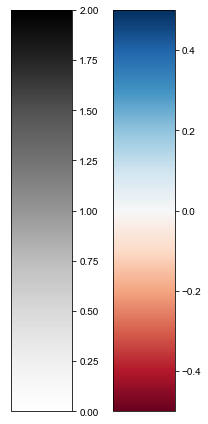

In [58]:
fig, ax = plt.subplots(figsize=(3, 6), ncols=2)
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=2)
norm_2 = mpl.colors.Normalize(vmin = -0.5, vmax=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax[0], cmap=cmap,
                                norm=norm,
                                )

cb2 = mpl.colorbar.ColorbarBase(ax[1], cmap=mpl.cm.RdBu,
                                norm=norm_2,
                                )
fig.tight_layout()
fig.savefig('colorbars.svg')

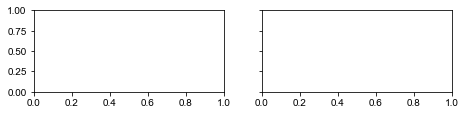

In [60]:
fig, ax = plt.subplots(ncols = 2, figsize = (7.5, 1.5), sharey=True)

sns.barplot(ax = ax[0], # Left plot
            data = df.loc[df.probe_name.isin(['ACTB', 'MYC']), :] # Replace gene names as necessary
            x = 'probe_name',
           )
sns.barplot(ax = ax[1], # Left plot
            data = df.loc[df.probe_name.isin(['ACTB', 'MYC']), :] # Replace gene names as necessary
            x = 'probe_name',
           )

long_string = ('This is text on line1'
               ' and this is more text but it\'s also on line 1'
              )

"""
ax[0].set_ylabel('')
ax[1].set_ylabel('')
"""

"""
for a in ax:
    a.set_ylabel(‘’)
    a.set_yticklabels('')
"""

fig.savefig()

In [ ]:
fig,ax = plt.subplots(figsize = (2, 4))

tick_loc = mpl.ticker.MultipleLocator(base=3.0)

ax.matshow(sense_data['gl3_rh'].iloc[np.argsort(used_genes.mean_sense_reads)[::-1], :] / million_mapped['gl3_rh'],
           extent = [-3, 3, 0, 15],
           cmap = 'Greys',
           vmin = 0, vmax = 1
          )
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

In [39]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

In [40]:
def mean_95_ci(ax, mat, color='blue'):
    ax.plot(np.arange(-3, 3, 0.01), mat.mean(axis=0), color=color)
    ax.fill_between(np.arange(-3, 3, 0.01), 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

In [41]:
len(sense_data['gl3_rh'])

12227

In [36]:
plt.plot(expr_genes.mean(axis=0))

NameError: name 'expr_genes' is not defined

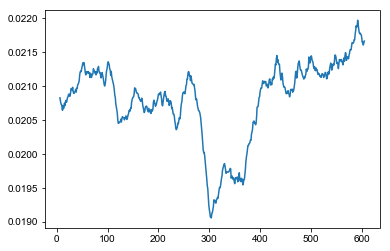

In [24]:
plt.plot(expr_genes.mean(axis=0))

In [42]:
type(expr_genes)

pandas.core.frame.DataFrame

In [44]:
bootstrapped = {}
bootstrapped['IP'] = bootstrap_samples(expr_genes.as_matrix(), 10000, verbose=True, sample_name='IP')
bootstrapped['RH'] = bootstrap_samples(expr_rh.as_matrix(), 10000, verbose=True, sample_name='RH')
bootstrapped['IN'] = bootstrap_samples(expr_in.as_matrix(), 10000, verbose=True, sample_name='Input')

IP 0.0
IP 4.0
IP 8.0
IP 12.0
IP 16.0
IP 20.0
IP 24.0
IP 28.000000000000004
IP 32.0
IP 36.0
IP 40.0
IP 44.0
IP 48.0
IP 52.0
IP 56.00000000000001
IP 60.0
IP 64.0
IP 68.0
IP 72.0
IP 76.0
IP 80.0
IP 84.0
IP 88.0
IP 92.0
IP 96.0
RH 0.0
RH 4.0
RH 8.0
RH 12.0
RH 16.0
RH 20.0
RH 24.0
RH 28.000000000000004
RH 32.0
RH 36.0
RH 40.0
RH 44.0
RH 48.0
RH 52.0
RH 56.00000000000001
RH 60.0
RH 64.0
RH 68.0
RH 72.0
RH 76.0
RH 80.0
RH 84.0
RH 88.0
RH 92.0
RH 96.0
Input 0.0
Input 4.0
Input 8.0
Input 12.0
Input 16.0
Input 20.0
Input 24.0
Input 28.000000000000004
Input 32.0
Input 36.0
Input 40.0
Input 44.0
Input 48.0
Input 52.0
Input 56.00000000000001
Input 60.0
Input 64.0
Input 68.0
Input 72.0
Input 76.0
Input 80.0
Input 84.0
Input 88.0
Input 92.0
Input 96.0


In [ ]:
bootstrapped['g_skew'] = bootstrap_samples(gc_skew.as_matrix(), 1000, verbose=True)

In [ ]:
fig, ax = plt.subplots(nrows = 2, figsize=(5,5), sharex=True)

mean_95_ci(ax[0], bootstrapped['g_skew'], color=down_color)
mean_95_ci(ax[1], bootstrapped['IP'], color=down_color)
mean_95_ci(ax[1], bootstrapped['RH'] , color=up_color)
mean_95_ci(ax[1], bootstrapped['IN'], color='#444444')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
labels = ['Mean IP', 'IP +RH', 'Input']
ax[1].legend(handles,labels, frameon=False)

ax[0].set_ylabel('GC-skew')
ax[1].set_ylabel('qDRIP IP signal')
ax[1].set_xlabel('Distance upstream of TSS')

fig.savefig('GC_skew_vs_R-loops.svg')

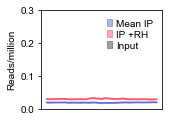

In [51]:
fig, ax = plt.subplots(figsize=(2.5,1.8))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
ax.xaxis.set_visible(False)
ax.set_ylabel('Reads/million')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
labels = ['Mean IP', 'IP +RH', 'Input']
ax.legend(handles,labels, frameon=False, labelspacing=0.2, handlelength=0.5, handletextpad=0.4, )
ax.set_ylim(0, 0.3)
fig.tight_layout()
fig.savefig('non_expr_Mean_IP_all_categories.pdf', transparent=True)
fig.savefig('non_expr_Mean_IP_all_categories.svg', transparent=True)

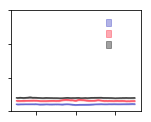

In [55]:
fig, ax = plt.subplots(figsize=(2.2,1.8))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
mean_95_ci(ax, bootstrapped['IN'], color='#444444')
ax.set_ylabel('Reads/million')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
for t in ax.get_xticklabels():
    t.set_visible(False)
for t in ax.get_yticklabels():
    t.set_visible(False)
ax.set_ylabel('')
labels = ['      ', '      ', '      ']
ax.legend(handles,labels, frameon=False, labelspacing=0.2, handlelength=0.5, handletextpad=0.4, )
ax.set_ylim(0, 0.3)
fig.tight_layout()
fig.savefig('non_expr_Mean_IP_all_categories.pdf', transparent=True)
fig.savefig('non_expr_Mean_IP_all_categories_nolabel.svg', transparent=True)

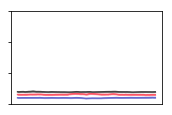

In [49]:
fig, ax = plt.subplots(figsize=(2.5,1.7))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
mean_95_ci(ax, bootstrapped['IN'], color='#444444')
ax.xaxis.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(0, 0.3)

fig.tight_layout()
fig.savefig('Mean_IP_all_categories.pdf', transparent=True)
fig.savefig('Mean_IP_all_categories.svg', transparent=True)

In [105]:
?ax.legend